In [1]:
import data_preparation as dd

import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import re

train_1 = pd.read_csv('../web-traffic-time-series-forecasting/train_1.csv')

In [2]:
data = dd.data_per_date(train_1)

In [3]:
ML = dd.find_page(data, 'Machine_learning')

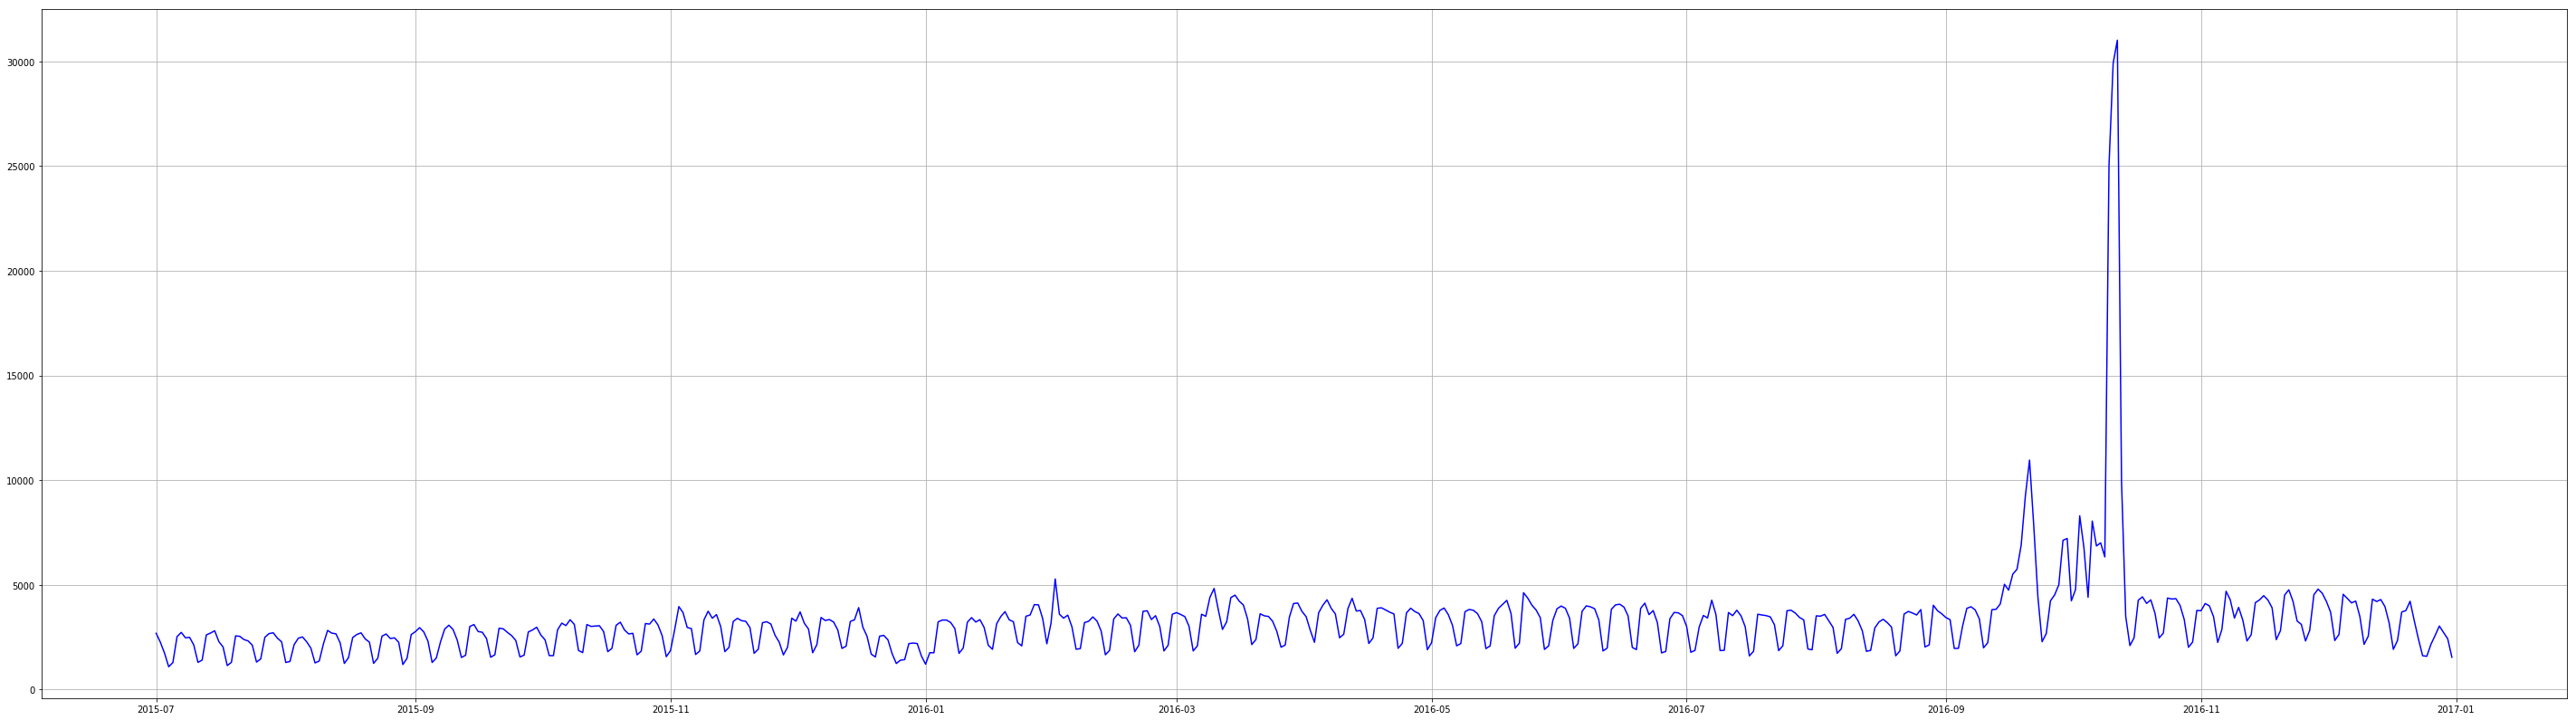

In [4]:
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
plt.figure(figsize=(50, 14))
plt.plot(ML, color = 'b')
plt.grid()
plt.show()

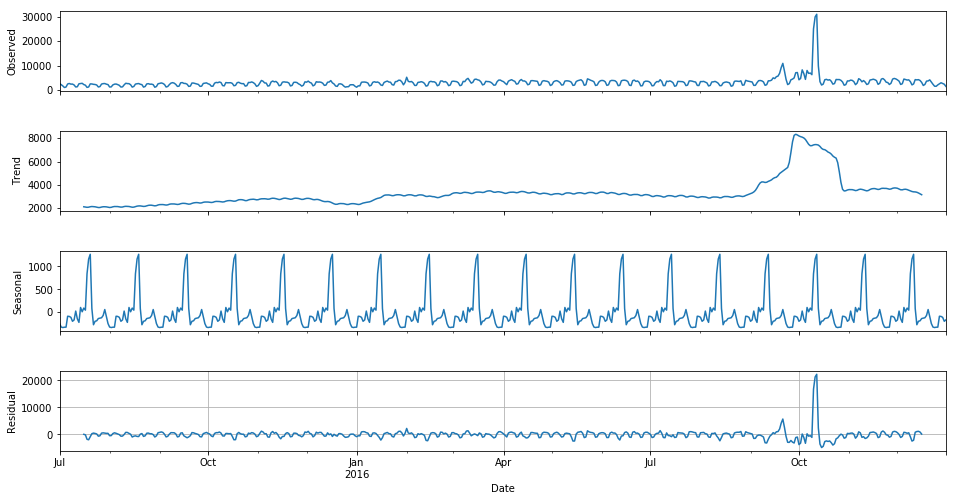

In [5]:
import statsmodels.api as sm

res = sm.tsa.seasonal_decompose(ML,freq=30, model = 'additive')
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.grid()
plt.show()

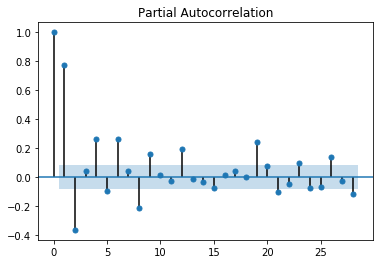

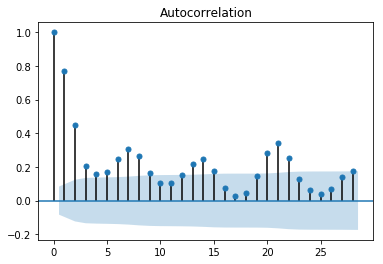

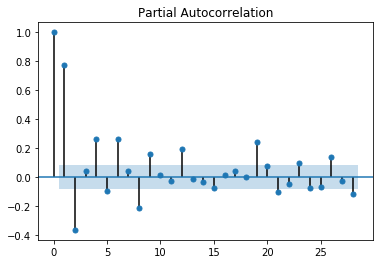

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ML['count'])
plot_pacf(ML['count'])

In [7]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

#resDiff = sm.tsa.arma_order_select_ic(my_page['count'],\
#                                      max_ar=7, max_ma=7, ic='aic', trend='c')
#print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

In [8]:
import arima_prep as aa

size = int(0.80*len(ML))
train, test = aa.series_split(ML, size)

train_deseasoned = aa.difference(train, 30)

arima = sm.tsa.statespace.SARIMAX(train_deseasoned,order=(7,1,7),seasonal_order=(0,0,0,0),\
                                  enforce_stationarity=False,\
                                  enforce_invertibility=False,).fit()

/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [9]:
from sklearn.metrics import mean_absolute_error

pred_deseasoned = arima.predict(size+1, len(ML))

pred = []
for yhat in pred_deseasoned:
    pred.append(aa.inverse_difference(train, yhat, 30))


print('ARIMA model MAE:{}'.format(mean_absolute_error(test,pred)))

ARIMA model MAE:3281.104712956467


/usr/local/lib/python3.7/site-packages/matplotlib/legend.py:449: UserWarning: The handle <matplotlib.lines.Line2D object at 0x114dfafd0> has a label of '_line0' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


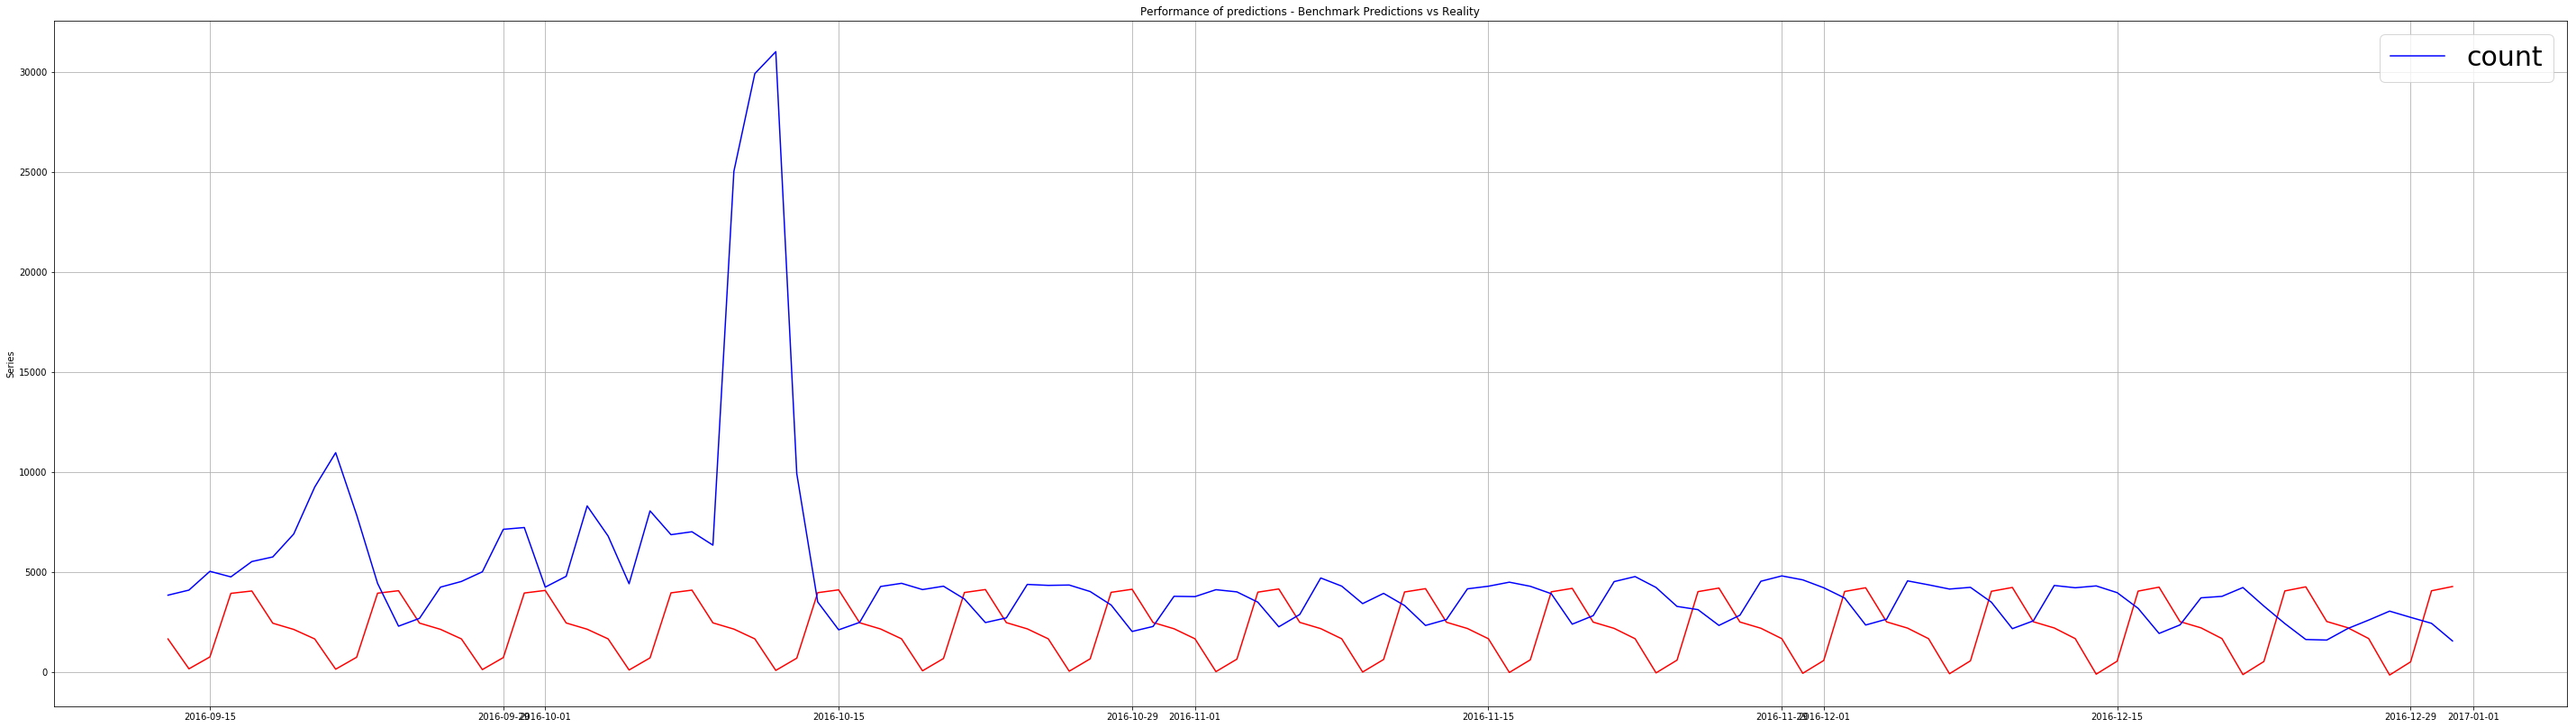

In [10]:
plt.figure(figsize=(50, 14))
line_up, = plt.plot(test.index, pred, color ='r')
line_down, = plt.plot(test.index, test, color = 'b')
plt.legend(handles=[line_up, line_down], prop={'size': 30})
plt.ylabel('Series')
plt.title('Performance of predictions - Benchmark Predictions vs Reality')
plt.grid()
plt.show()

In [11]:
prediction2 = aa.rolling_forecast(train, test, ARIMA, 1,1,1)

mae = mean_absolute_error(test, prediction2)
print ("-----------------------------------------------")
print ("mae with 80% of the data to train:", mae)
print ("-----------------------------------------------")

-----------------------------------------------
mae with 80% of the data to train: 1311.0913123404448
-----------------------------------------------


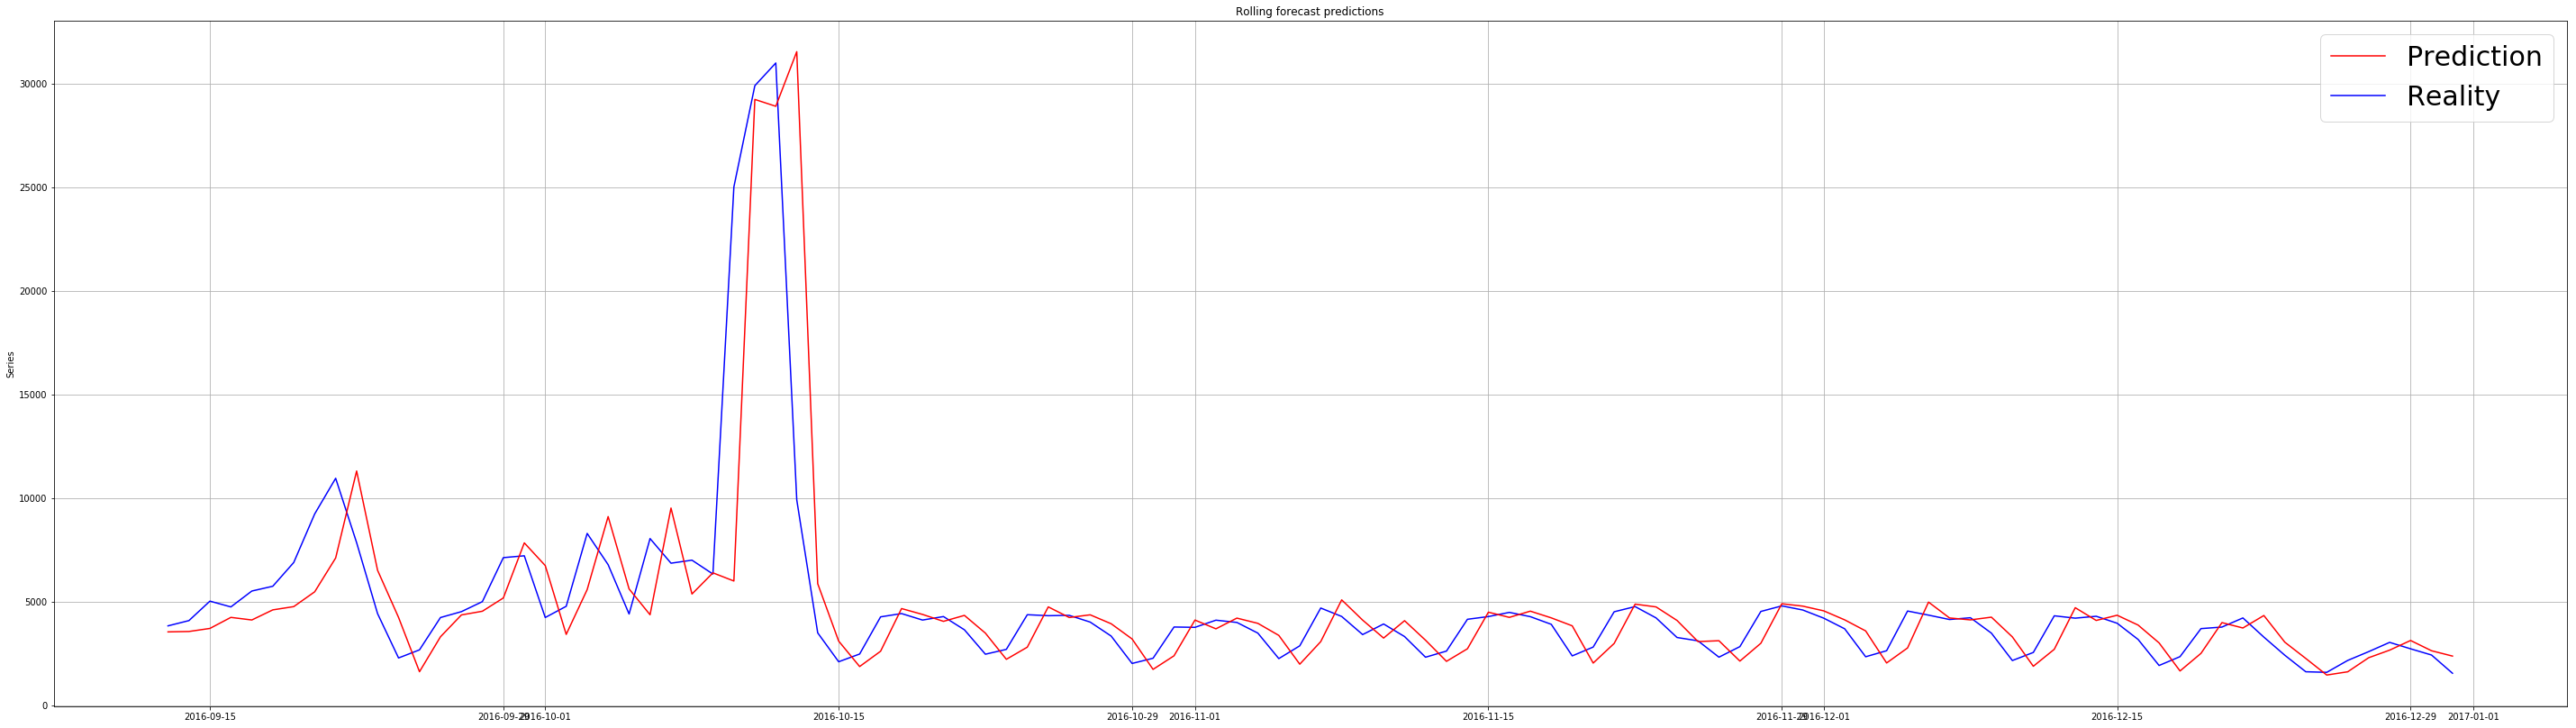

In [12]:
plt.figure(figsize=(50, 14))
line_down, = plt.plot(test,label='Reality', color = 'b')
line_up, = plt.plot(test.index, prediction2,label='Prediction', color = 'r')
plt.ylabel('Series')
plt.legend(handles=[line_up, line_down], prop={'size': 30})
plt.title('Rolling forecast predictions')
plt.grid()
plt.show()

In [13]:
FB = dd.divide_page_by_lang(data, 'ASCII')

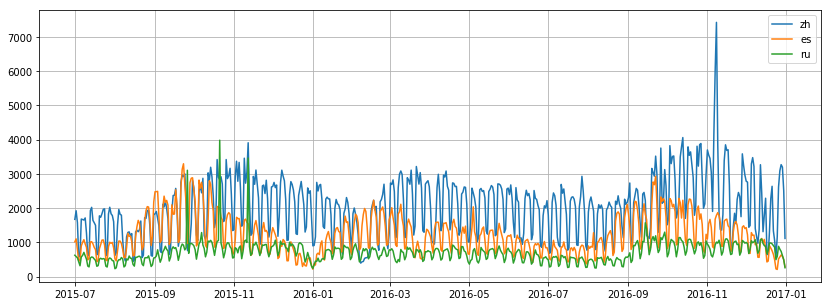

In [14]:
for key in FB.columns:
    fig = plt.figure(1,figsize=[14,5])
    plt.plot(FB[key], label = key )
plt.legend()
plt.grid()
plt.show()

In [15]:
import warnings
warnings.filterwarnings('ignore')

train = FB[0:size]
test = FB[size+1: len(data)]

predictions3 = aa.rolling_forecast_var(train, test,sm.tsa.VARMAX, 1,0)
    
mae = mean_absolute_error(test, predictions3)
print ("-----------------------------------------------")
print ("mae with 80% of the data to train:", mae)
print ("-----------------------------------------------")

-----------------------------------------------
mae with 80% of the data to train: 405.41238337813775
-----------------------------------------------


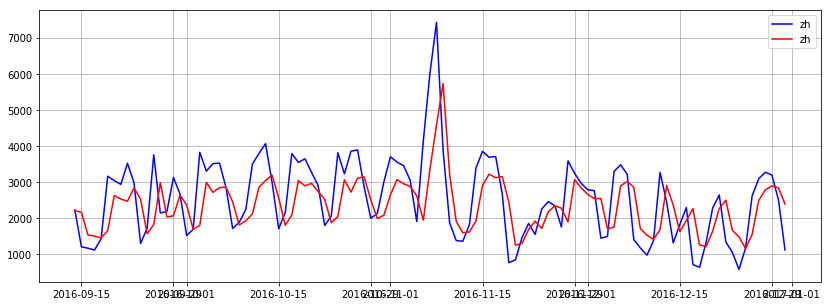

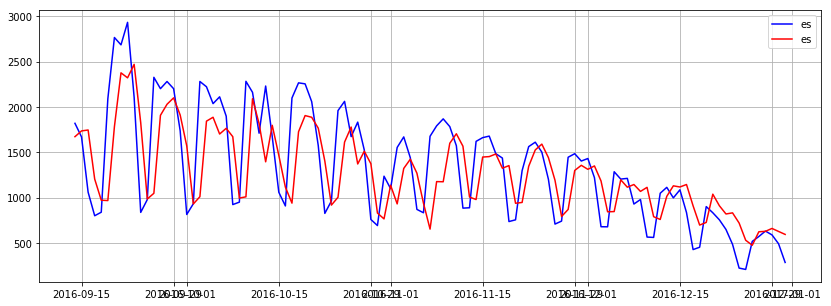

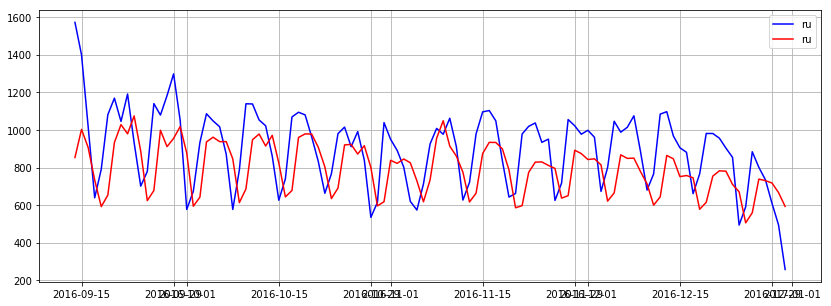

In [17]:
predictions3.index = test.index
for key in FB.columns:
    fig = plt.figure(1,figsize=[14,5])
    plt.plot(test[key], label = key, color = 'b' )
    plt.plot(predictions3[key], label = key, color = 'r' )
    plt.legend()
    plt.grid()
    plt.show()